# Beyond Naïve Bayes: complex Bayesian Network Architectures
Build two or three Bayes networks of more complex architecture for (a smaller version of) this data set, increasing the number
of connections among the nodes. Construct one of them semi-manually (e.g use K2 algorithm and vary the maximum number of parents), and two others – using Weka’s algorithms for learning Bayes net construction (e.g. use TAN or Hill Climbing algorithms). Run the experiments described in item 5 on these new Bayes network architectures. Record, compare and analyse the outputs, in the light of the previous conclusions about the given data. 

# To go in submission notebook

In [7]:
from Scripts import helperfn as hf
from Scripts import pixelFinder as pf 
from Scripts import downsample as ds
from Scripts.NaiveBayse import NaiveBayseGaussian as nbg
from Scripts import bayseNet as bn
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
import networkx as nx
import math
import numpy as np
import pandas as pd
from pgmpy.estimators import BayesianEstimator, HillClimbSearch, ExhaustiveSearch, K2Score, MaximumLikelihoodEstimator, BicScore, BDeuScore



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocess data
### Get equal width binned data and labels

In [19]:
X, y = hf.get_data(4)

#### Select most predicitve pixels

In [24]:
pixels = pf.get_top_pixels(2304, downscaled=False)

Progress: [####################] 100.0%


In [33]:
pixels = pf.grab_n_pixels(pixels, 15)

## Build all networks
### Search for edges and network parameters. Once the model is build score it.
This may take a while, depending on the variable dependencies.

In [34]:
bn.build_networks(pixels, ewb=True, balance_by_class=True)

Progress: [##########----------] 48.4%


KeyboardInterrupt: 

In [20]:
pixels = pf.get_top_pixels(5, downscaled=False)
# pixels is list of best pixels for all datasets: pixels[0] is all classes | pixels[1] is speed limit 20...
x_pixels = np.take(X, pixels[5], axis=1)
x_pixels.shape

(9690, 5)

In [21]:
x_pixels

,983,1031,1030,982,935
0,205.0,180.0,155.0,191.0,228.0
1,163.0,136.0,132.0,141.0,197.0
2,165.0,120.0,135.0,142.0,204.0
3,143.0,134.0,127.0,136.0,179.0
4,226.0,190.0,151.0,212.0,236.0
...,...,...,...,...,...
9685,111.0,112.0,110.0,113.0,112.0
9686,107.0,107.0,107.0,107.0,107.0
9687,106.0,106.0,104.0,103.0,102.0
9688,99.0,100.0,99.0,97.0,98.0


#### Select a balanced class distrubution from the data and append labels to data

In [6]:
y.columns = ['y']
x_bal_pixels, y_pixels = hf.balance_by_class(x_pixels, y)
X_train, x_test, y_train, y_test = train_test_split(x_bal_pixels, y_pixels, random_state=0, test_size=0.2)
X_pixels = X_train.join(y_train)

## Build model
#### Learn edges with K2 parents = 4, HillClimbing algorithm

In [7]:
hillClimb = bn.estimate_model_edges(X_pixels)

---- Beginning edge estimator ----
---- Done ----


#### Learn model parameters using BDeu as the estimator

In [8]:
hillClimb.edges

OutEdgeView([('983', '935'), ('983', '982'), ('983', 'y'), ('1031', '983'), ('1031', 'y'), ('1030', '982'), ('1030', '1031'), ('982', 'y'), ('935', 'y')])

In [9]:
model = bn.model_with_params(X_pixels, hillClimb.edges, estimator=BayesianEstimator, prior_type="K2")

['983', '935', '982', 'y', '1031', '1030']


In [10]:
nb_edges = bn.get_naive_edges(pixels[5])

[('983', 'y'), ('1031', 'y'), ('1030', 'y'), ('982', 'y'), ('935', 'y')]

In [11]:
nb_model = bn.model_with_params(X_pixels, nb_edges, estimator=BayesianEstimator, prior_type="K2")

['983', 'y', '1031', '1030', '982', '935']


In [32]:
print(model.get_independencies())
print(model.local_independencies('y'))


(983 _|_ 1030 | 1031)
(983 _|_ 1030 | 1031, 935)
(935 _|_ 1030 | 1031)
(935 _|_ 1031, 982, 1030 | 983)
(935 _|_ 982, 1030 | 1031, 983)
(935 _|_ 1031, 1030 | 983, 982)
(935 _|_ 1031, 982 | 983, 1030)
(935 _|_ 1030 | 1031, 983, 982)
(935 _|_ 982 | 1031, 983, 1030)
(935 _|_ 1031 | 983, 982, 1030)
(935 _|_ 1030 | 1031, y, 983, 982)
(982 _|_ 935 | 983)
(982 _|_ 935 | 1031, 983)
(982 _|_ 1031, 935 | 983, 1030)
(982 _|_ 935 | 1031, 983, 1030)
(982 _|_ 1031 | 935, 983, 1030)
(y _|_ 1030 | 1031, 983, 982)
(y _|_ 1030 | 1031, 935, 983, 982)
(1031 _|_ 935 | 983)
(1031 _|_ 935 | 983, 982)
(1031 _|_ 935, 982 | 983, 1030)
(1031 _|_ 982 | 935, 983, 1030)
(1031 _|_ 935 | 983, 982, 1030)
(1030 _|_ 935, 983 | 1031)
(1030 _|_ 935 | 983)
(1030 _|_ 983 | 1031, 935)
(1030 _|_ 935 | 1031, 983)
(1030 _|_ 935 | 983, 982)
(1030 _|_ y, 935 | 1031, 983, 982)
(1030 _|_ y | 1031, 935, 983, 982)
(1030 _|_ 935 | 1031, y, 983, 982)
(y _|_ 1030 | 1031, 935, 983, 982)


In [33]:
print(nb_model.get_independencies())
print(nb_model.local_independencies('y'))

(983 _|_ 1031, 935, 982, 1030)
(983 _|_ 935, 982, 1030 | 1031)
(983 _|_ 1031, 982, 1030 | 935)
(983 _|_ 1031, 935, 1030 | 982)
(983 _|_ 1031, 935, 982 | 1030)
(983 _|_ 982, 1030 | 1031, 935)
(983 _|_ 935, 1030 | 1031, 982)
(983 _|_ 935, 982 | 1031, 1030)
(983 _|_ 1031, 1030 | 935, 982)
(983 _|_ 1031, 982 | 935, 1030)
(983 _|_ 1031, 935 | 982, 1030)
(983 _|_ 1030 | 1031, 935, 982)
(983 _|_ 982 | 1031, 935, 1030)
(983 _|_ 935 | 1031, 982, 1030)
(983 _|_ 1031 | 935, 982, 1030)
(1031 _|_ 935, 983, 982, 1030)
(1031 _|_ 983, 982, 1030 | 935)
(1031 _|_ 935, 982, 1030 | 983)
(1031 _|_ 935, 983, 1030 | 982)
(1031 _|_ 935, 983, 982 | 1030)
(1031 _|_ 982, 1030 | 935, 983)
(1031 _|_ 983, 1030 | 935, 982)
(1031 _|_ 983, 982 | 935, 1030)
(1031 _|_ 935, 1030 | 983, 982)
(1031 _|_ 935, 982 | 983, 1030)
(1031 _|_ 935, 983 | 982, 1030)
(1031 _|_ 1030 | 935, 983, 982)
(1031 _|_ 982 | 935, 983, 1030)
(1031 _|_ 983 | 935, 982, 1030)
(1031 _|_ 935 | 983, 982, 1030)
(1030 _|_ 1031, 935, 983, 982)
(1030 _|_ 9

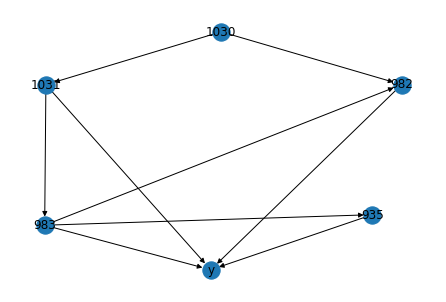

In [12]:
nx.draw(model, with_labels=True)

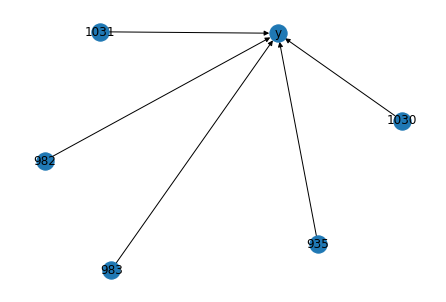

In [13]:
nx.draw(nb_model, with_labels=True)

In [14]:
infer = bn.get_inference_model(model)
infer_nb = bn.get_inference_model(nb_model)

## Score the model

### Score model with hill climb edges:

In [82]:
hc_score = bn.score_model(infer, x_test, y_test)
print('--- Scoring model Complete ---')

Progress: [####################] 99.9%
Prediction:  1
Actual:  1
True Negative


Score:  0.7297979797979798
--- Scoring model Complete ---


### Score model with naive edges:

In [83]:
naive_score = bn.score_model(infer_nb, x_test, y_test)
print('--- Scoring model Complete ---')

Progress: [####################] 99.9%


Score:  0.7424242424242424
--- Scoring model Complete ---


In [74]:
print(hc_score)
#print(nb_score)

(0, 0, 2, 0)


In [17]:
pixels[5]

array([ 983, 1031, 1030,  982,  935], dtype=int64)

In [62]:
ev = x_test.iloc[789].to_dict()

q = infer.map_query(variables=['y'], evidence=ev)
print()
print()
print(q)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

{'y': 1}



In [53]:
ev = x_test.iloc[0].to_dict()

q = infer_nb.map_query(variables=['y'], evidence=ev)
print()
print()
print(q.get('y'))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

1



In [72]:
x_test.iloc[788:790]

,983,1031,1030,982,935
1120,semi light grey,semi light grey,semi dark grey,dark grey,light grey
9289,white,white,white,white,white


In [70]:
x_test.iloc[788].to_dict()

{'983': 'semi light grey',
 '1031': 'semi light grey',
 '1030': 'semi dark grey',
 '982': 'dark grey',
 '935': 'light grey'}

In [79]:
y_test.iloc[788]

y    1
Name: 1120, dtype: object